In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import shutil
import seaborn as sns
from glob import glob
import PIL
from PIL import Image
from statistics import mode
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [2]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import json

with open('kaggle.json') as f:
    data = json.load(f)

api_key = data['key']
print(api_key)


fabff1e48ae65b22e0f662e7a6237e66


In [6]:
import opendatasets as od
import pandas as pd

# Download the dataset
dataset_url = "https://www.kaggle.com/datasets/farjanakabirsamanta/skin-cancer-dataset?resource=download"
od.download(dataset_url)


100%|██████████| 2.58G/2.58G [00:33<00:00, 82.8MB/s]


In [7]:
# Specify the correct file path
csv_file = '/content/skin-cancer-dataset/HAM10000_metadata.csv'

# Load the metadata CSV file into a DataFrame
metadata = pd.read_csv(csv_file)

# Drop the specified columns
metadata.drop(['lesion_id', 'dx_type', 'age', 'sex', 'localization'], axis=1, inplace=True)

# Display the first 5 rows of the modified DataFrame
print(metadata.head(5))

       image_id   dx
0  ISIC_0027419  bkl
1  ISIC_0025030  bkl
2  ISIC_0026769  bkl
3  ISIC_0025661  bkl
4  ISIC_0031633  bkl


In [8]:
metadata.dx.value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [9]:
le = LabelEncoder()
metadata['dx'] = le.fit_transform(metadata.dx)

In [10]:
metadata.dx.value_counts()

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: dx, dtype: int64

In [ ]:
# Membagi dataset menjadi dua bagian (80% dan 20%) train_val dan test
train_data, test_data = train_test_split(metadata, test_size=0.2, random_state=42)

In [ ]:
print('Length of training data', len(train_data))
print('Length of testing data',len(test_data))
print('Length of meta data',len(metadata))
print(f'Total Images = {len(train_data)} + {len(test_data)} = {len(train_data) + len(test_data)}')

Length of training data 8012
Length of testing data 2003
Length of meta data 10015
Total Images = 8012 + 2003 = 10015


In [ ]:
path = "/content/drive/MyDrive/Skin Cancer/"

In [ ]:
# Dapatkan daftar kategori unik
categories = train_data['dx'].unique()

# Buat folder untuk setiap kategori
for category in categories:
    os.makedirs(path + 'train/' + str(category), exist_ok=True)

# Loop melalui setiap baris dalam file CSV
for index, row in train_data.iterrows():
    filename = row['image_id']  # Ubah 'filename' dengan nama kolom yang berisi nama file gambar
    category = row['dx']  # Ubah 'label' dengan nama kolom yang berisi kategori
    source_path = '/content/skin-cancer-dataset/Skin Cancer/Skin Cancer/' + filename + '.jpg' # Ubah 'path/to/images/' dengan direktori tempat gambar-gambar Anda disimpan
    
    # Salin gambar ke folder yang sesuai
    destination_path = os.path.join(path + 'train/' + str(category), filename + '.jpg')
    shutil.copy(source_path, destination_path)

In [ ]:
# Dapatkan daftar kategori unik
categories = test_data['dx'].unique()

# Buat folder untuk setiap kategori
for category in categories:
    os.makedirs(path + 'test/' + str(category), exist_ok=True)

# Loop melalui setiap baris dalam file CSV
for index, row in test_data.iterrows():
    filename = row['image_id']  # Ubah 'filename' dengan nama kolom yang berisi nama file gambar
    category = row['dx']  # Ubah 'label' dengan nama kolom yang berisi kategori
    source_path = '/content/skin-cancer-dataset/Skin Cancer/Skin Cancer/' + filename + '.jpg' # Ubah 'path/to/images/' dengan direktori tempat gambar-gambar Anda disimpan
    
    # Salin gambar ke folder yang sesuai
    destination_path = os.path.join(path + 'test/' + str(category), filename + '.jpg')
    shutil.copy(source_path, destination_path)

In [11]:
train_path = "/content/drive/MyDrive/Skin Cancer/train/"
test_path = "/content/drive/MyDrive/Skin Cancer/test/"


IMG_HEIGHT = 100
IMG_WIDTH = 100
channels = 3

NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

7

In [12]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = train_path + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

In [13]:
len(image_data)

8012

In [14]:
# shuffle_indexes = np.arange(image_data.shape[0])
# np.random.shuffle(shuffle_indexes)
# image_data = image_data[shuffle_indexes]
# image_labels = image_labels[shuffle_indexes]

In [15]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (5608, 100, 100, 3)
X_valid.shape (2404, 100, 100, 3)
y_train.shape (5608,)
y_valid.shape (2404,)


In [16]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(5608, 7)
(2404, 7)


In [17]:
# base = tf.keras.applications.resnet50.ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, channels),
#                                            include_top=False,
#                                            weights='imagenet')

model = Sequential()
model.add(Conv2D(32, (3,3), input_shape = (IMG_HEIGHT, IMG_WIDTH, channels), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))
model.add(Conv2D(256, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(7, activation="softmax" , name="classification"))

In [18]:
model.compile(loss  = 'categorical_crossentropy', optimizer = 'Adam', metrics = 'acc')

In [19]:
from keras.callbacks import ReduceLROnPlateau
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_acc', patience=3, verbose=1, 
    factor=0.5, min_lr=0.00001)

In [20]:
#Augmenting the data and training the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

epochs = 20
history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=aug.flow(X_val, y_val, batch_size=32))

Epoch 1/20
176/176 [==============================] - 33s 116ms/step - loss: 1.0329 - acc: 0.6721 - val_loss: 1.0272 - val_acc: 0.6552
Epoch 2/20
176/176 [==============================] - 25s 142ms/step - loss: 0.9623 - acc: 0.6762 - val_loss: 1.0117 - val_acc: 0.6556
Epoch 3/20
176/176 [==============================] - 21s 121ms/step - loss: 0.9074 - acc: 0.6760 - val_loss: 0.8851 - val_acc: 0.6639
Epoch 4/20
176/176 [==============================] - 20s 112ms/step - loss: 0.8423 - acc: 0.6940 - val_loss: 0.8580 - val_acc: 0.6830
Epoch 5/20
176/176 [==============================] - 21s 119ms/step - loss: 0.8227 - acc: 0.6978 - val_loss: 0.8610 - val_acc: 0.6889
Epoch 6/20
176/176 [==============================] - 19s 111ms/step - loss: 0.7954 - acc: 0.7051 - val_loss: 0.8418 - val_acc: 0.6631
Epoch 7/20
176/176 [==============================] - 23s 129ms/step - loss: 0.7787 - acc: 0.7081 - val_loss: 0.8080 - val_acc: 0.6926
Epoch 8/20
176/176 [==============================] - 2

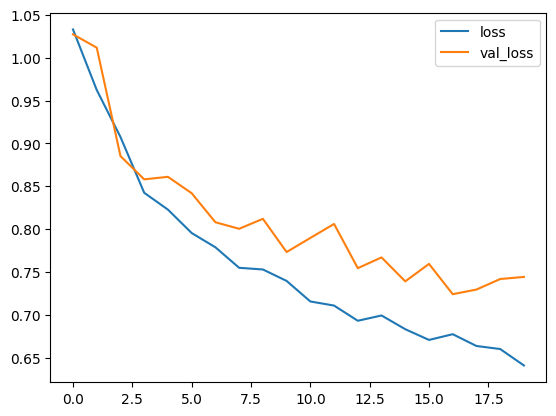

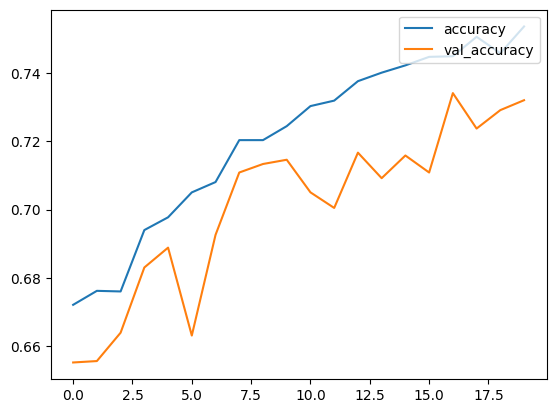

In [21]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

In [22]:
labels = []

data =[]

for i in range(NUM_CATEGORIES):
    path = test_path + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            data.append(np.array(resize_image))
            labels.append(int(i))
        except:
            print("Error in " + img)

X_test = np.array(data)
X_test = X_test/255

pred = np.argmax(model.predict(X_test),axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

63/63 [==============================] - 1s 9ms/step
Test Data accuracy:  74.08886669995007


In [23]:
# cf = confusion_matrix(labels, pred)
# import seaborn as sns
# df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
# plt.figure(figsize = (20,20))
# sns.heatmap(df_cm, annot=True)

In [24]:
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.50      0.04      0.08        69
           1       0.46      0.52      0.49        93
           2       0.48      0.47      0.47       228
           3       0.00      0.00      0.00        28
           4       0.60      0.22      0.32       226
           5       0.81      0.94      0.87      1338
           6       0.43      0.76      0.55        21

    accuracy                           0.74      2003
   macro avg       0.47      0.42      0.40      2003
weighted avg       0.71      0.74      0.71      2003



In [25]:
model.save_weights("model.h5")